In [1]:
# IO
import os

# Data
import numpy as np
import xarray as xr

# Plotting
import matplotlib.pyplot as plt
import cmcrameri  # nice colormaps

In [2]:
from thesis.io import fgong
from thesis.physics import first_adiabatic_exponent, sound_speed, acoustic_depth
from thesis.calculus import differentiate

In [3]:
root_path = "/Users/ajl573/OneDrive/Data/MESA/solar_models"
profile_name = "profile"

In [4]:
Ys = [0.0, 0.26, 0.28, 0.3]

In [5]:
models = {}
for Y in Ys:
    key = f"y{Y:.2f}"
    filename = os.path.join(root_path, key, ".".join([profile_name, "data", "FGONG"]))
    model = fgong.load_fgong(filename)
    model["cs"] = sound_speed(model.Gamma_1, model.P, model.rho)
    model["tau"] = acoustic_depth(model.r, model.cs, axis=0)
    models[Y] = model

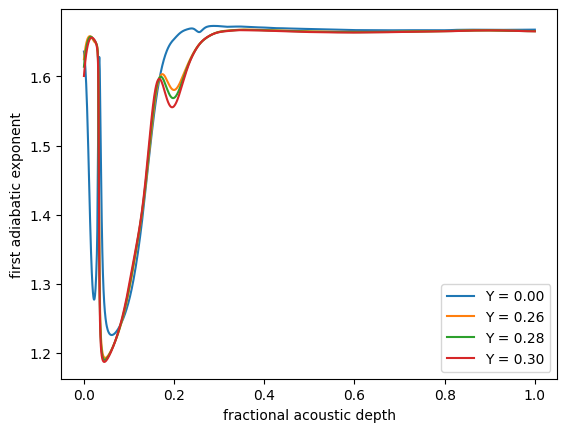

In [6]:
fig, ax = plt.subplots()

for Y in Ys:
    tau0 = models[Y].tau.max()
    ax.plot(models[Y].tau/tau0, models[Y].Gamma_1, label=f"Y = {Y:.2f}")
    
ax.set_xlabel("fractional acoustic depth")
ax.set_ylabel("first adiabatic exponent")
ax.legend();

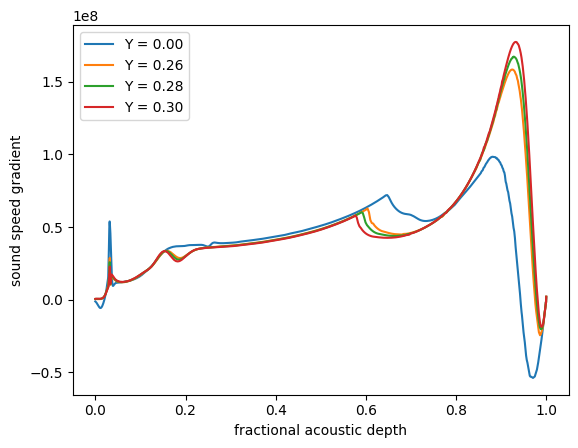

In [7]:
fig, ax = plt.subplots()

for Y in Ys:
    tau0 = models[Y].tau.max()
    ax.plot(models[Y].tau/tau0, tau0*differentiate(models[Y].cs, models[Y].tau), label=f"Y = {Y:.2f}")
    
ax.set_xlabel("fractional acoustic depth")
ax.set_ylabel("sound speed gradient")
ax.legend();